In [1]:
# Input info
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/clones/"
# N_DONORS = 2
# condition = "inputOnly" # noInput

#config
input_cond = "Input"
clone_col = "name"
atac_col = "cluster_labels"

# params
min_clone_size = 2
p_thresh = 0.1 

n_cpus = 8

n_shuffle=1000
#conds_sep = False


se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clones/variants_prefilterMerge_impute/knn/kparam_30/cells_meta.tsv" 
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clonal_shifts/variants_prefilterMerge_impute/clones/results/noInput/knn/kparam_30" 

N_DONORS = 5 
condition = "noInput" #inputOnly



In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)
    
if not exists(sep_dir):
    os.mkdir(sep_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
        
    
# sim_all_dir = join(all_dir, "shuffle")
# sim_sep_dir = join(sep_dir, "shuffle")
# if not exists(sep_dir):
#     os.mkdir(sep_dir)
# if not exists(sim_all_dir):
#     os.mkdir(sim_all_dir)


In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

## Load cells_meta

In [5]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t", index_col=0)
if cells_meta.index.duplicated().any():
    cells_meta = cells_meta.reset_index()
    
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Input_AAACGAATCGTGAACT-1,Input,5996,5996,66340.0,10716,362,165,2305,39978,12814,...,4,8689,5714,AAACGAATCGTGAACT-1_Input,Input_AAACGAATCGTGAACT-1,2,0,Input,0_2,4
Input_AAACTCGAGGTACACG-1,Input,4901,4901,49202.0,9164,265,116,1810,27219,10628,...,1,6092,4446,AAACTCGAGGTACACG-1_Input,Input_AAACTCGAGGTACACG-1,4,0,Input,0_4,1
Input_AAACTGCAGGATGTAT-1,Input,3421,3421,34970.0,5801,165,87,972,22347,5598,...,1,3701,2984,AAACTGCAGGATGTAT-1_Input,Input_AAACTGCAGGATGTAT-1,4,0,Input,0_4,1
Input_AAACTGCAGTCTCTAG-1,Input,3129,3129,31794.0,6835,210,90,1208,13249,10202,...,2,5219,3174,AAACTGCAGTCTCTAG-1_Input,Input_AAACTGCAGTCTCTAG-1,2,0,Input,0_2,2
Input_AAACTGCTCCTCCCAA-1,Input,4781,4781,38006.0,8486,256,107,2210,16894,10053,...,6,7519,5182,AAACTGCTCCTCCCAA-1_Input,Input_AAACTGCTCCTCCCAA-1,8,0,Input,0_8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_ATGTCTTGTGTCGTGC-1,Flt3l,8759,8759,155564.0,35841,999,490,3409,101832,12993,...,9,11376,6631,ATGTCTTGTGTCGTGC-1_Flt3l,Flt3l_ATGTCTTGTGTCGTGC-1,3,4,Flt3l,4_3,9
Flt3l_GTTGGTAAGCGAGAAA-1,Flt3l,7417,7417,159745.0,37109,832,641,3911,106447,10805,...,9,9416,5770,GTTGGTAAGCGAGAAA-1_Flt3l,Flt3l_GTTGGTAAGCGAGAAA-1,2,4,Flt3l,4_2,9
Flt3l_TGGGTGCAGTACCACT-1,Flt3l,8502,8502,187037.0,52900,784,1007,5934,112887,13525,...,9,11193,6675,TGGGTGCAGTACCACT-1_Flt3l,Flt3l_TGGGTGCAGTACCACT-1,3,4,Flt3l,4_3,9
Flt3l_TGGGTGCCAAGTTGCT-1,Flt3l,8723,8723,189721.0,45559,793,732,4374,124486,13777,...,9,10792,6534,TGGGTGCCAAGTTGCT-1_Flt3l,Flt3l_TGGGTGCCAAGTTGCT-1,3,4,Flt3l,4_3,9


## Map the new group to cells_meta

## Filter for condition

In [6]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
#sns.countplot(data=cells_meta,x=clone_col)
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Flt3l_CACTAAGGTACGAGAC-1,Flt3l,8901,8901,189296.0,45721,816,787,2984,122960,16028,...,9,13441,6757,CACTAAGGTACGAGAC-1_Flt3l,Flt3l_CACTAAGGTACGAGAC-1,12,0,Flt3l,0_12,9
Flt3l_GAGATTCCAGAACTTC-1,Flt3l,11142,11142,158188.0,53885,1215,780,3953,80257,18098,...,9,15225,7756,GAGATTCCAGAACTTC-1_Flt3l,Flt3l_GAGATTCCAGAACTTC-1,12,0,Flt3l,0_12,9
Flt3l_GTTGGTAGTTCTGAGT-1,Flt3l,6488,6488,190846.0,33953,717,719,3678,142218,9561,...,9,7659,5169,GTTGGTAGTTCTGAGT-1_Flt3l,Flt3l_GTTGGTAGTTCTGAGT-1,21,0,Flt3l,0_21,9
Flt3l_TCAGTTTAGCGCAATG-1,Flt3l,9383,9383,184974.0,57357,1187,776,6532,102632,16490,...,9,14536,7637,TCAGTTTAGCGCAATG-1_Flt3l,Flt3l_TCAGTTTAGCGCAATG-1,21,0,Flt3l,0_21,9
Flt3l_TGAGTCATCCGTCAAA-1,Flt3l,8169,8169,149784.0,36634,749,501,3632,95352,12916,...,13,10250,6071,TGAGTCATCCGTCAAA-1_Flt3l,Flt3l_TGAGTCATCCGTCAAA-1,12,0,Flt3l,0_12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_ATGTCTTGTGTCGTGC-1,Flt3l,8759,8759,155564.0,35841,999,490,3409,101832,12993,...,9,11376,6631,ATGTCTTGTGTCGTGC-1_Flt3l,Flt3l_ATGTCTTGTGTCGTGC-1,3,4,Flt3l,4_3,9
Flt3l_GTTGGTAAGCGAGAAA-1,Flt3l,7417,7417,159745.0,37109,832,641,3911,106447,10805,...,9,9416,5770,GTTGGTAAGCGAGAAA-1_Flt3l,Flt3l_GTTGGTAAGCGAGAAA-1,2,4,Flt3l,4_2,9
Flt3l_TGGGTGCAGTACCACT-1,Flt3l,8502,8502,187037.0,52900,784,1007,5934,112887,13525,...,9,11193,6675,TGGGTGCAGTACCACT-1_Flt3l,Flt3l_TGGGTGCAGTACCACT-1,3,4,Flt3l,4_3,9
Flt3l_TGGGTGCCAAGTTGCT-1,Flt3l,8723,8723,189721.0,45559,793,732,4374,124486,13777,...,9,10792,6534,TGGGTGCCAAGTTGCT-1_Flt3l,Flt3l_TGGGTGCCAAGTTGCT-1,3,4,Flt3l,4_3,9


## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

donor 0
['0_12' '0_21' '0_6']
[ 4  9 12 13]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 1
bh shape (3, 4)


ic| 'clone min'


out_df   index variable  value      method
1  0_21        4    0.0  global_all
8   0_6       12    0.0  global_all
9  0_12       13    0.0  global_all
1  0_21        4    0.0  global_min
8   0_6       12    0.0  global_min
9  0_12       13    0.0  global_min
1  0_21        4    0.0   clone_all
8   0_6       12    0.0   clone_all
9  0_12       13    0.0   clone_all
1  0_21        4    0.0   clone_min
8   0_6       12    0.0   clone_min
9  0_12       13    0.0   clone_min
donor 1
['1_13' '1_15' '1_19' '1_22' '1_26' '1_33']
[ 9 13]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'
ic

Number of groups below p-val significance: 0


| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 2
bh shape (6, 2)


ic| 'clone min'


out_df    index variable  value      method
0   1_13        9    0.0  global_all
1   1_15        9    0.0  global_all
2   1_19        9    0.0  global_all
3   1_22        9    0.0  global_all
4   1_26        9    0.0  global_all
11  1_33       13    0.0  global_all
0   1_13        9    0.0  global_min
1   1_15        9    0.0  global_min
2   1_19        9    0.0  global_min
3   1_22        9    0.0  global_min
4   1_26        9    0.0  global_min
11  1_33       13    0.0  global_min
0   1_13        9    0.0   clone_all
1   1_15        9    0.0   clone_all
2   1_19        9    0.0   clone_all
3   1_22        9    0.0   clone_all
4   1_26        9    0.0   clone_all
11  1_33       13    0.0   clone_all
0   1_13        9    0.0   clone_min
1   1_15        9    0.0   clone_min
2   1_19        9    0.0   clone_min
3   1_22        9    0.0   clone_min
4   1_26        9    0.0   clone_min
11  1_33       13    0.0   clone_min
donor 2
only 1 cluster. not running
donor 3
['3_0']
[ 3  9 10 13 14]

/mnt/md0/isshamie/Projects/Mito_Trace/src/clonal_shifts.py:506: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure()
ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'
ic| 

Number of groups below p-val significance: 0


'clone all'


axs 1
bh shape (1, 5)


ic| 'clone min'


out_df   index variable  value      method
0   3_0        3    0.0  global_all
1   3_0        9    0.0  global_all
2   3_0       10    0.0  global_all
3   3_0       13    0.0  global_all
4   3_0       14    0.0  global_all
0   3_0        3    0.0  global_min
1   3_0        9    0.0  global_min
2   3_0       10    0.0  global_min
3   3_0       13    0.0  global_min
4   3_0       14    0.0  global_min
0   3_0        3    0.0   clone_all
1   3_0        9    0.0   clone_all
2   3_0       10    0.0   clone_all
3   3_0       13    0.0   clone_all
4   3_0       14    0.0   clone_all
0   3_0        3    0.0   clone_min
1   3_0        9    0.0   clone_min
2   3_0       10    0.0   clone_min
3   3_0       13    0.0   clone_min
4   3_0       14    0.0   clone_min
donor 4
only 1 cluster. not running


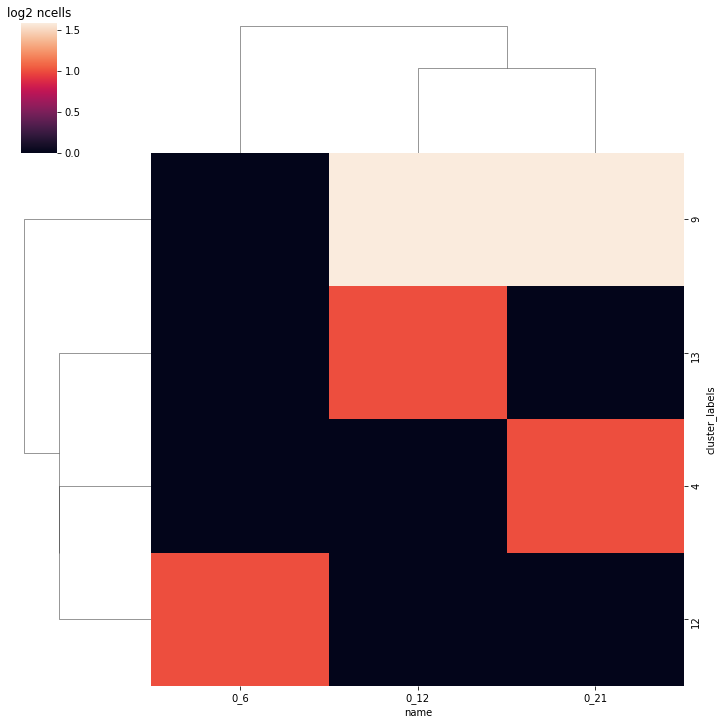

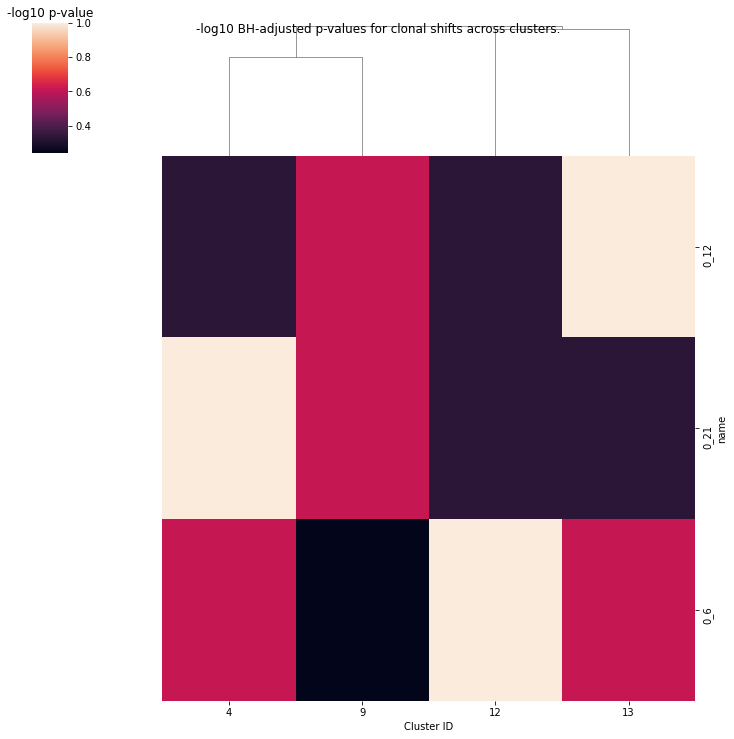

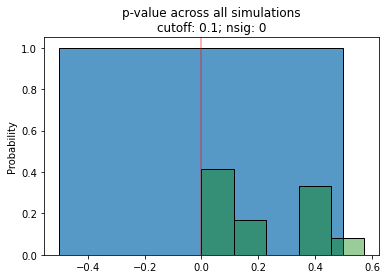

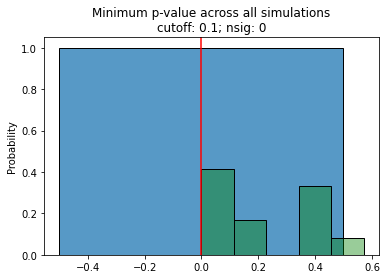

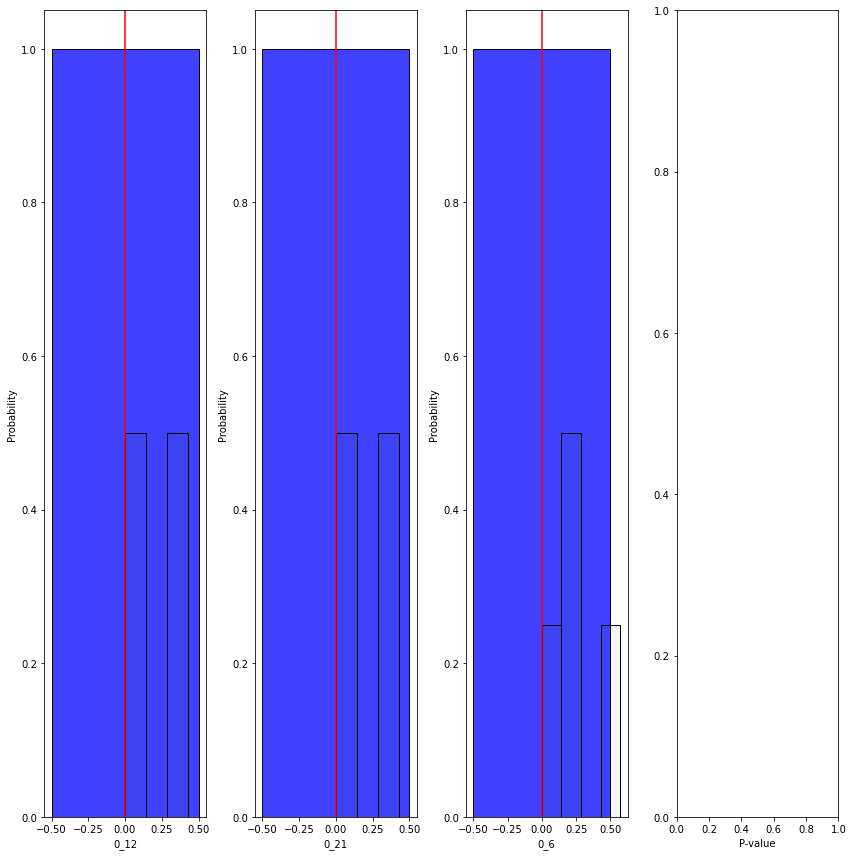

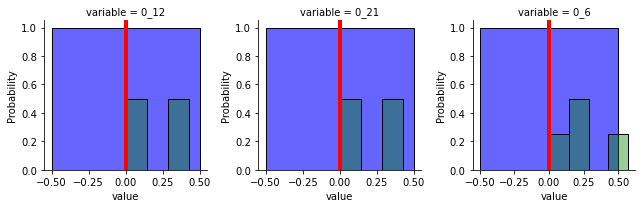

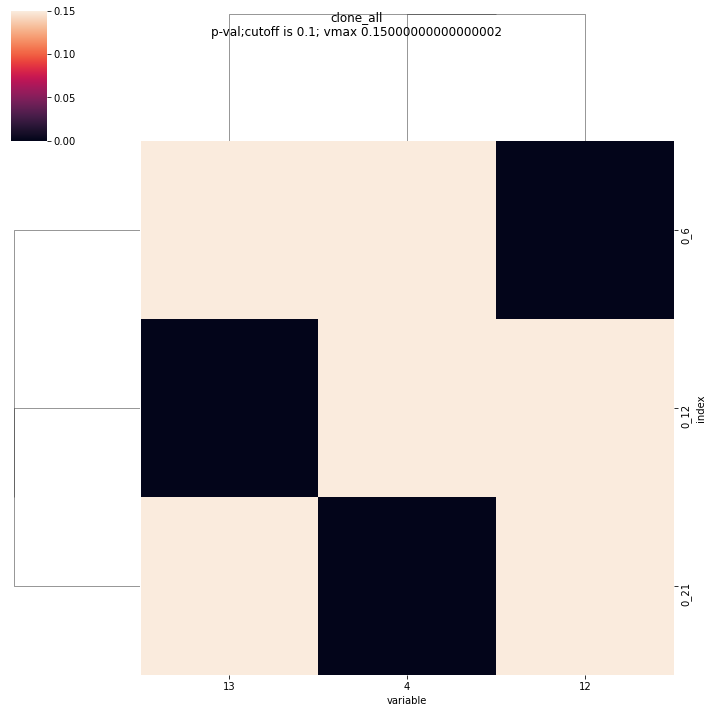

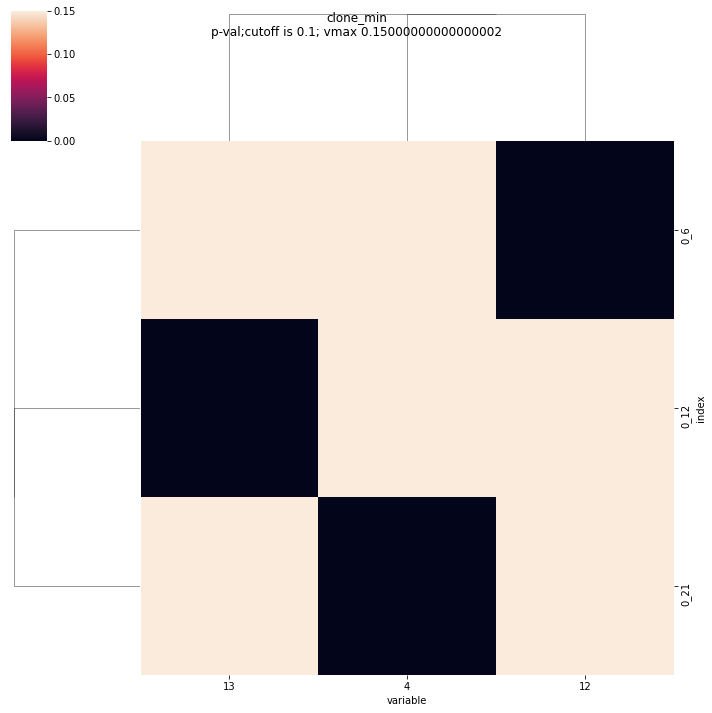

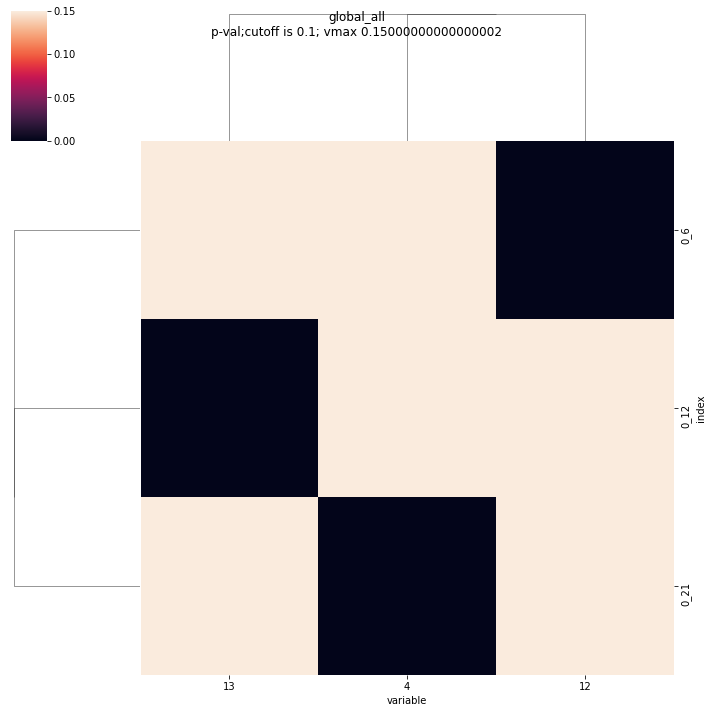

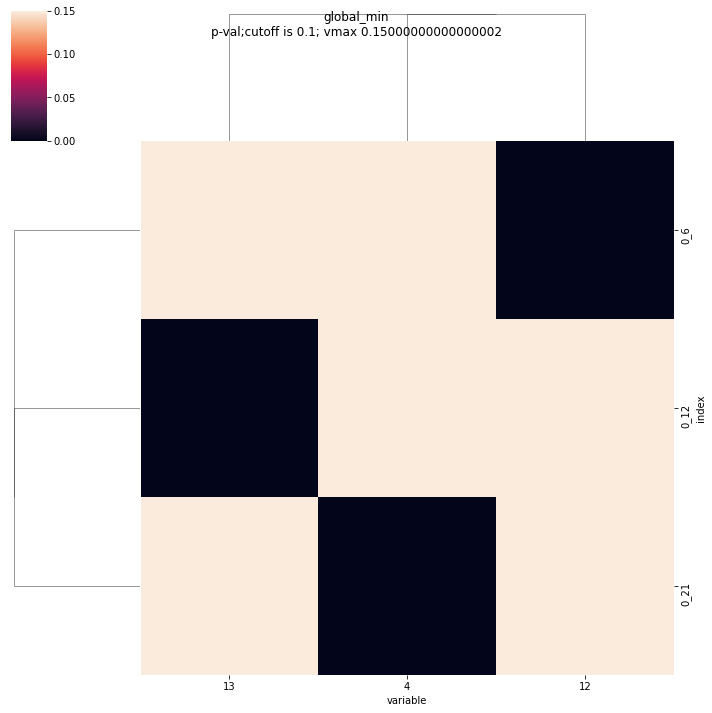

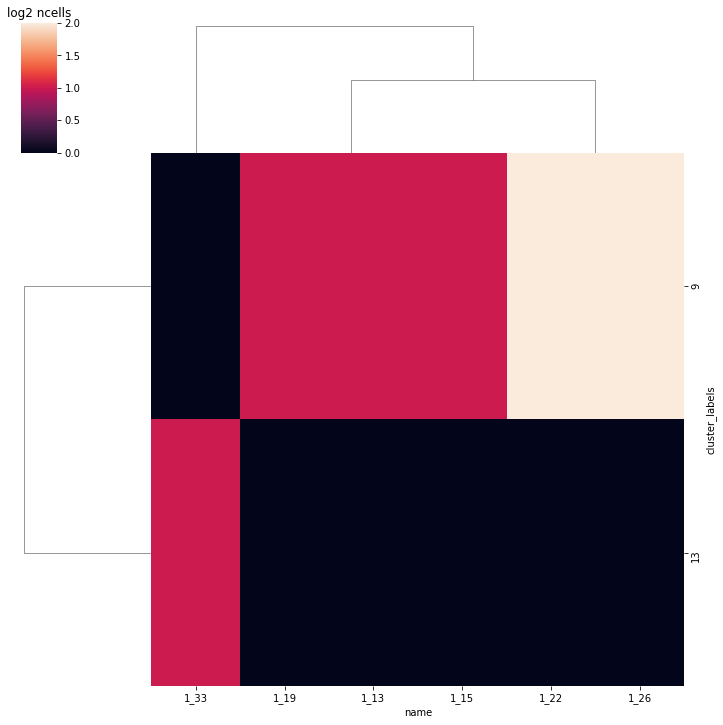

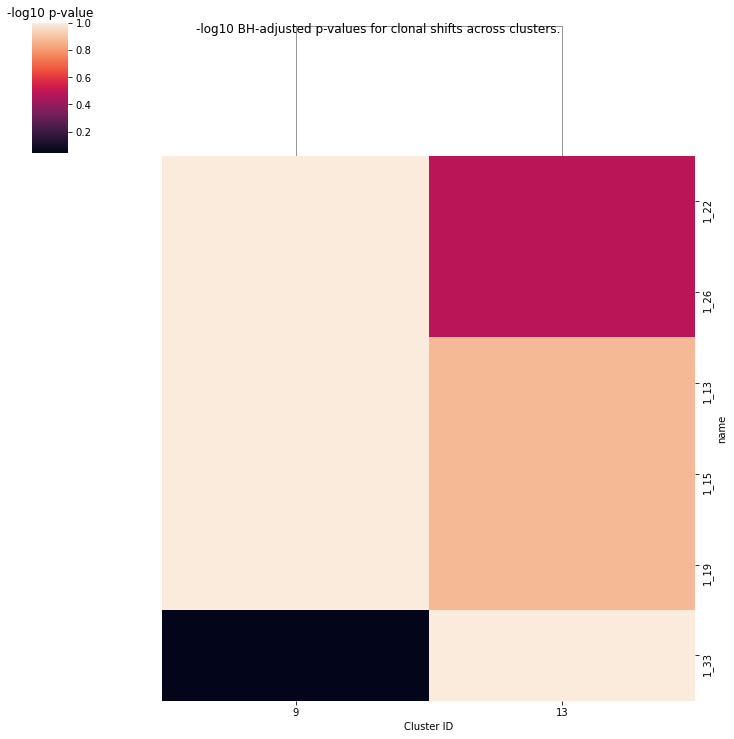

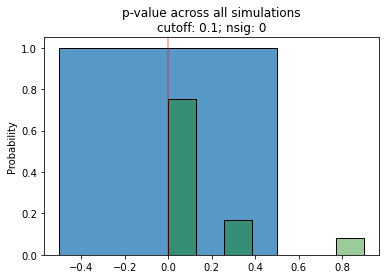

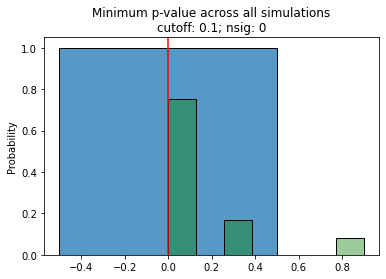

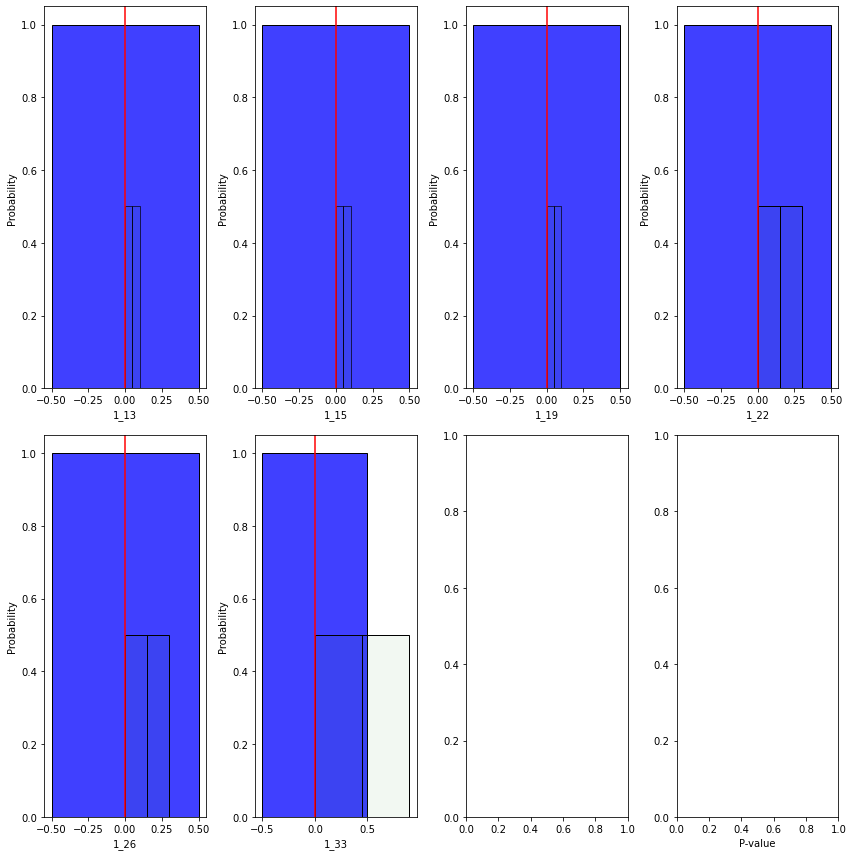

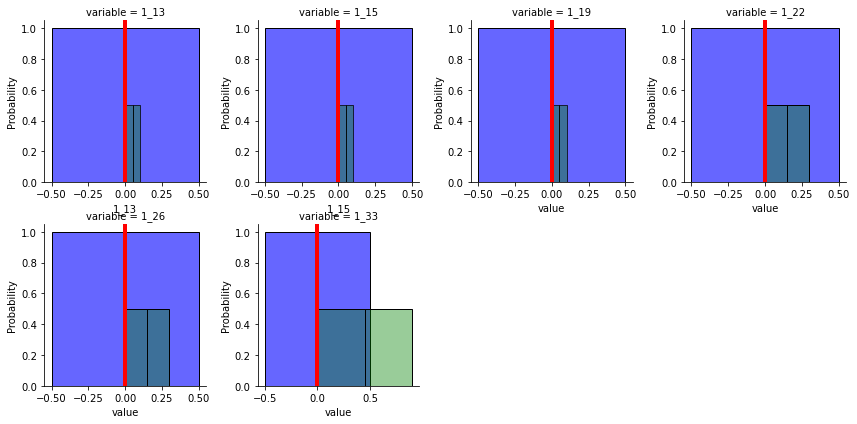

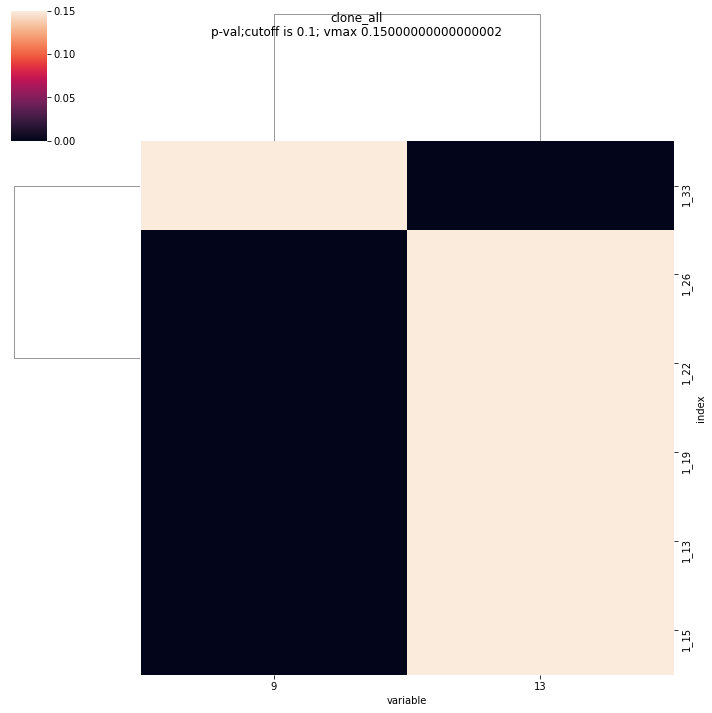

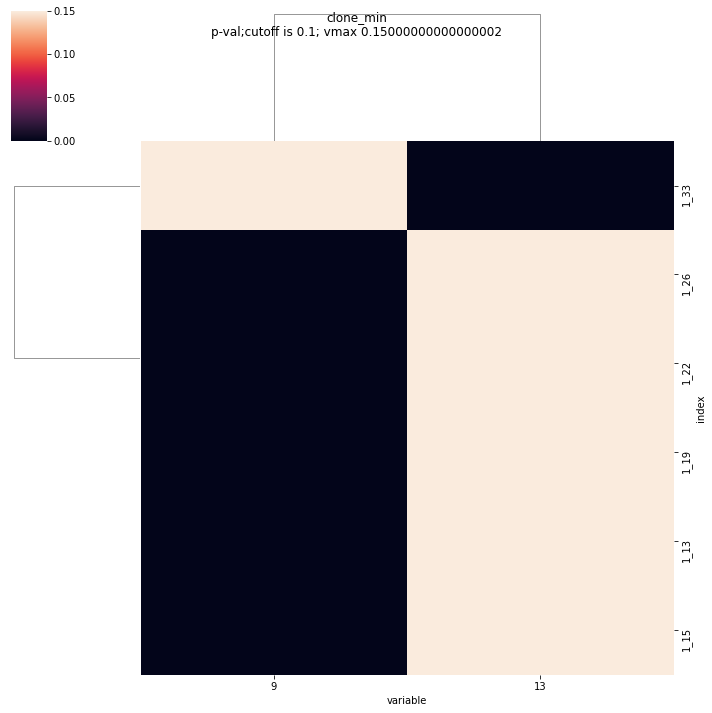

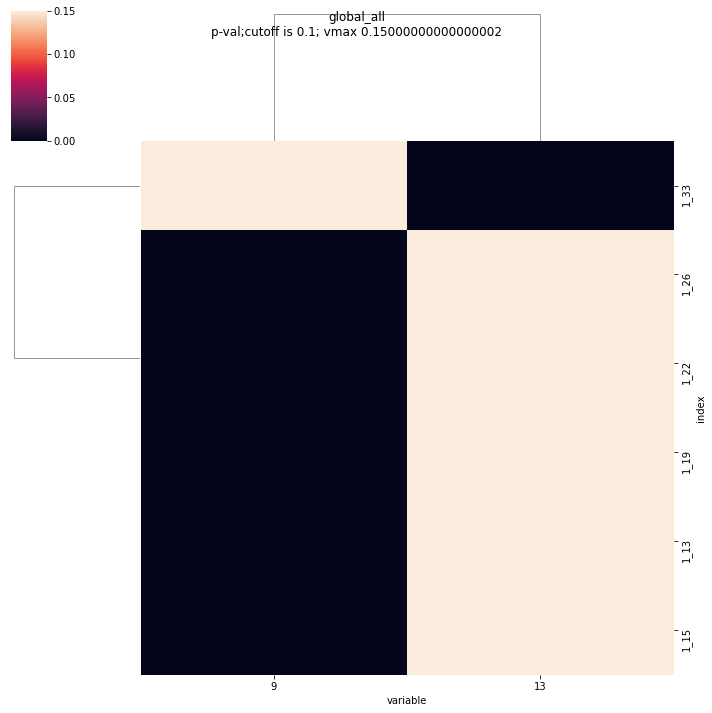

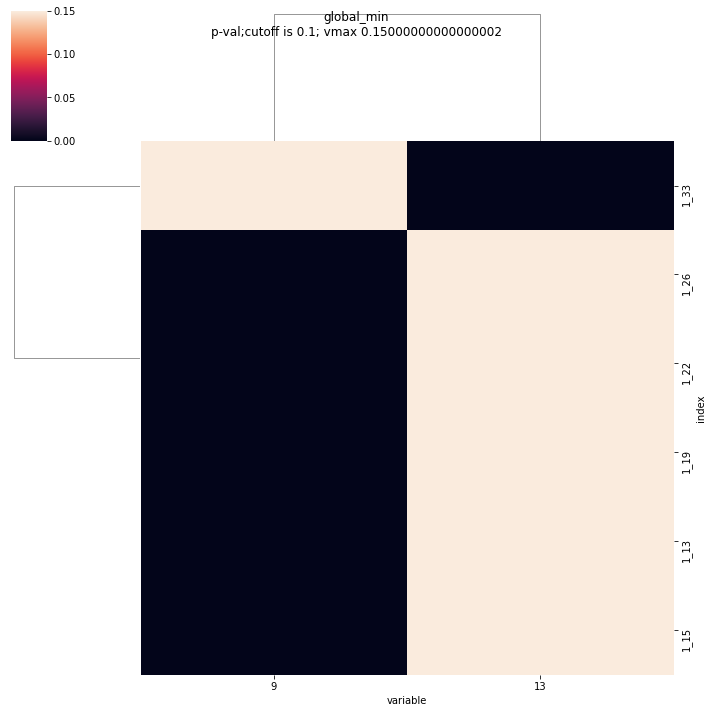

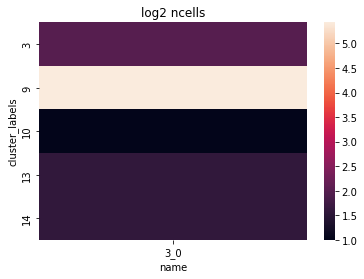

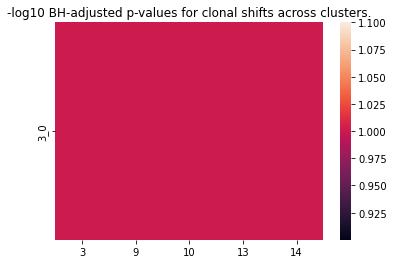

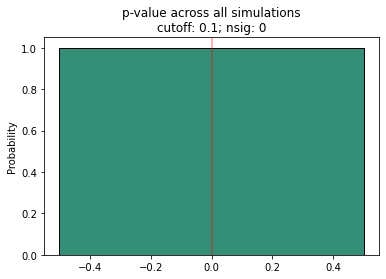

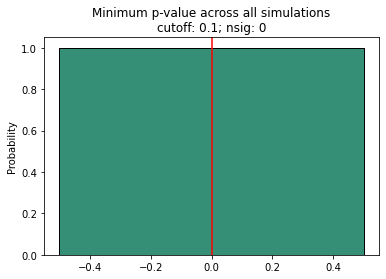

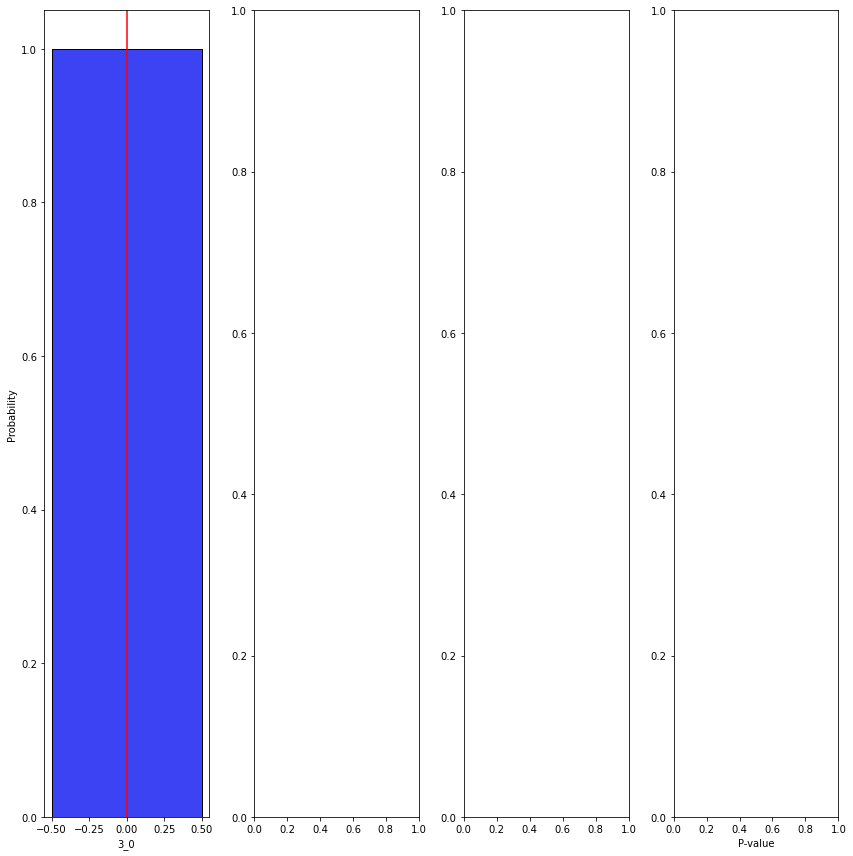

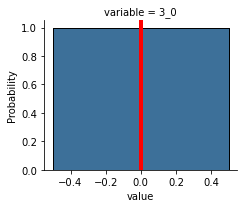

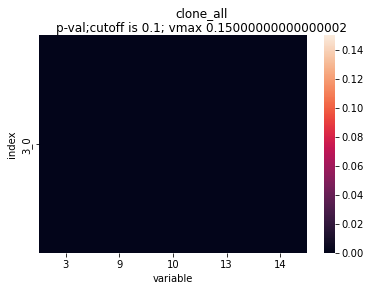

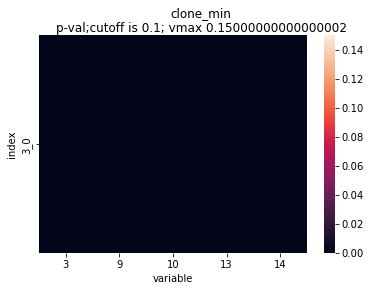

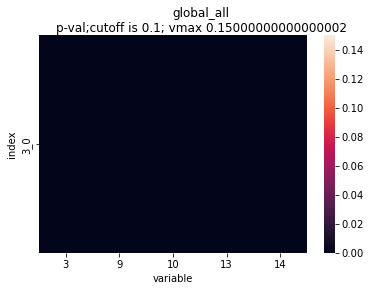

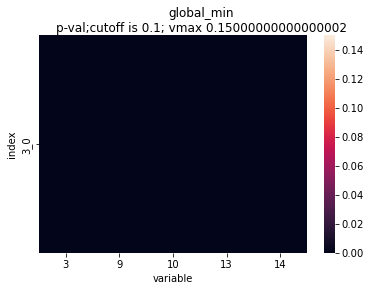

In [7]:
for d, val in cells_meta.groupby("donor"):
    print('donor', d)
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    if len(curr_groups["cluster_labels"].unique()) == 1:
        print('only 1 cluster. not running')
        continue
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)

#     print("plotting counts")
#     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
#     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(curr_don_out, "ncells.png"))
#     curr_groups = curr_groups.drop("log2_count", axis=1)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)

    
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     g.fig.suptitle(f"Hypergeometric distribution p-values - non-significant values (p={p_thresh}) are zeroes")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=n_cpus)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    


## B) Run using all donors as background

Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 2
bh shape (6, 7)


ic| 'clone min'


out_df    index variable  value      method
4    3_0        3    0.0  global_all
7   0_21        4    0.0  global_all
14  1_22        9    0.0  global_all
15  1_26        9    0.0  global_all
17   4_3        9    0.0  global_all
22   3_0       10    0.0  global_all
40   3_0       14    0.0  global_all
4    3_0        3    0.0  global_min
7   0_21        4    0.0  global_min
14  1_22        9    0.0  global_min
15  1_26        9    0.0  global_min
17   4_3        9    0.0  global_min
22   3_0       10    0.0  global_min
40   3_0       14    0.0  global_min
4    3_0        3    0.0   clone_all
7   0_21        4    0.0   clone_all
14  1_22        9    0.0   clone_all
15  1_26        9    0.0   clone_all
17   4_3        9    0.0   clone_all
22   3_0       10    0.0   clone_all
40   3_0       14    0.0   clone_all
4    3_0        3    0.0   clone_min
7   0_21        4    0.0   clone_min
14  1_22        9    0.0   clone_min
15  1_26        9    0.0   clone_min
17   4_3        9    0.0   clon

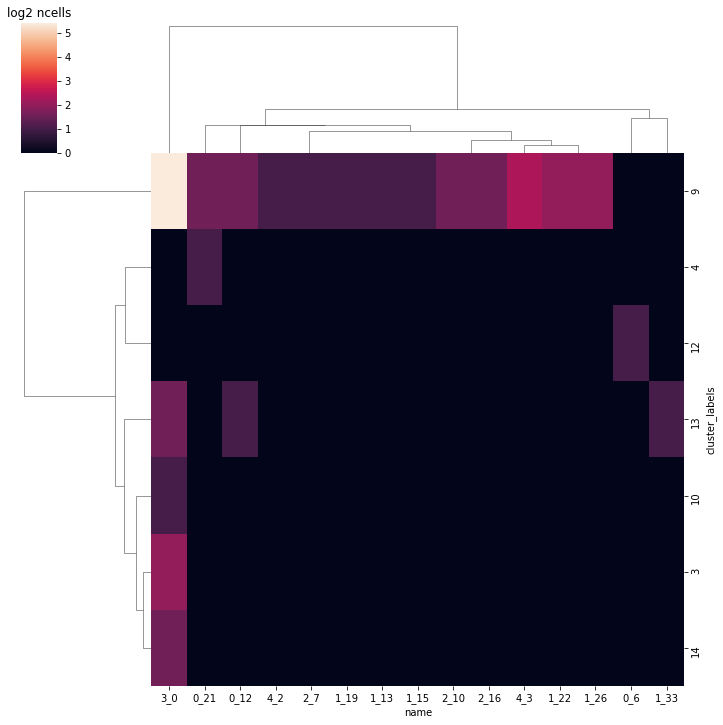

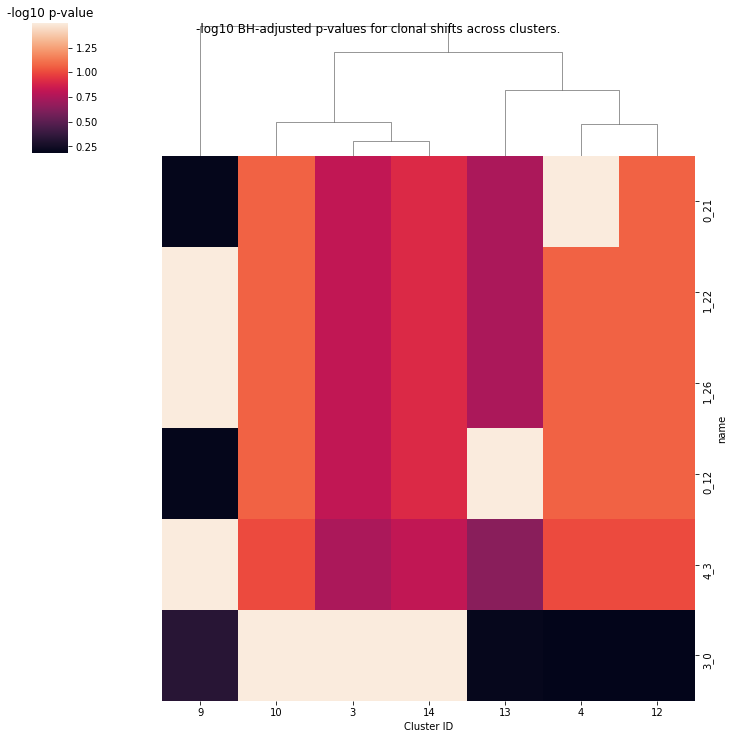

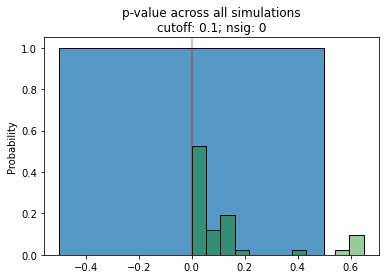

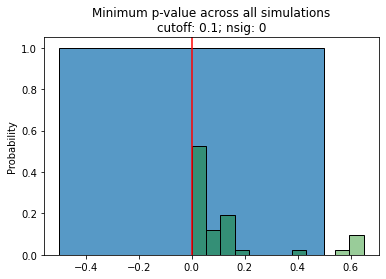

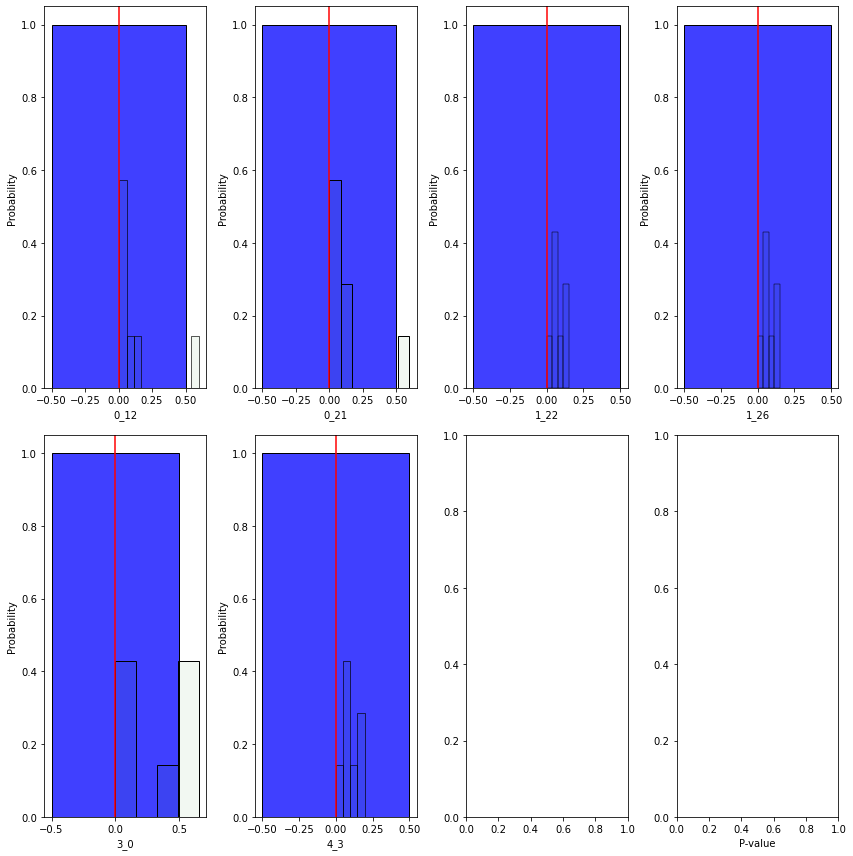

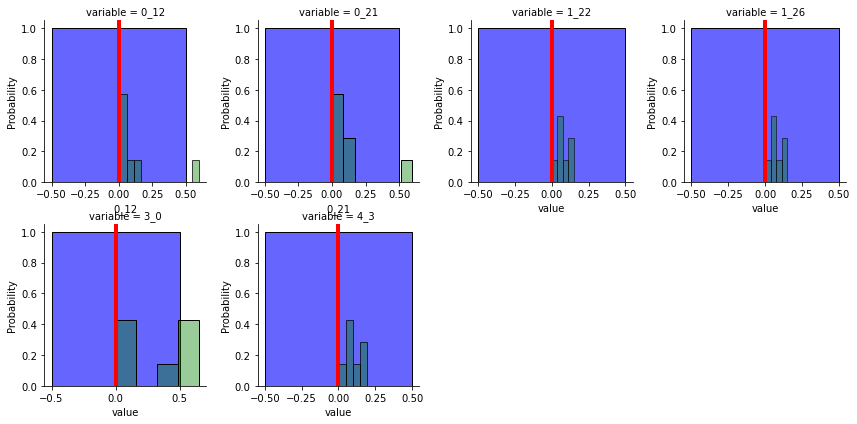

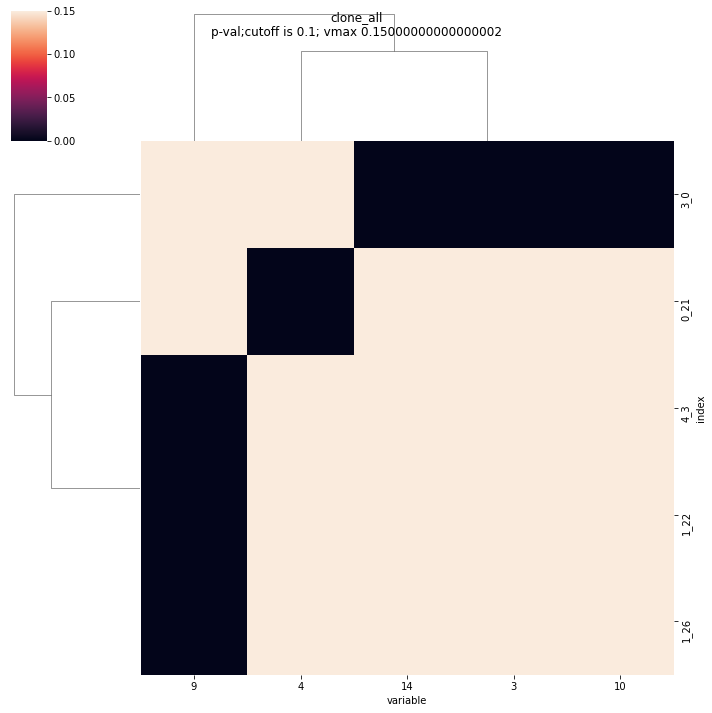

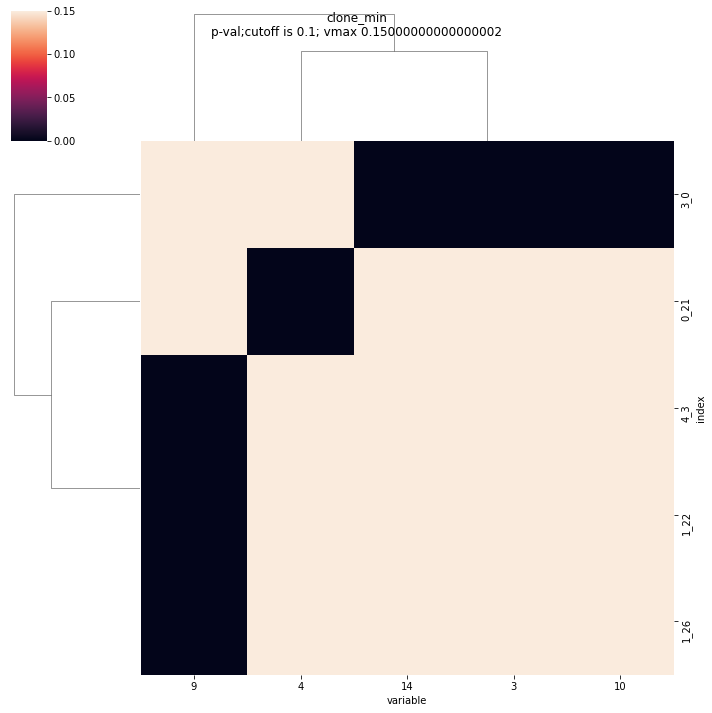

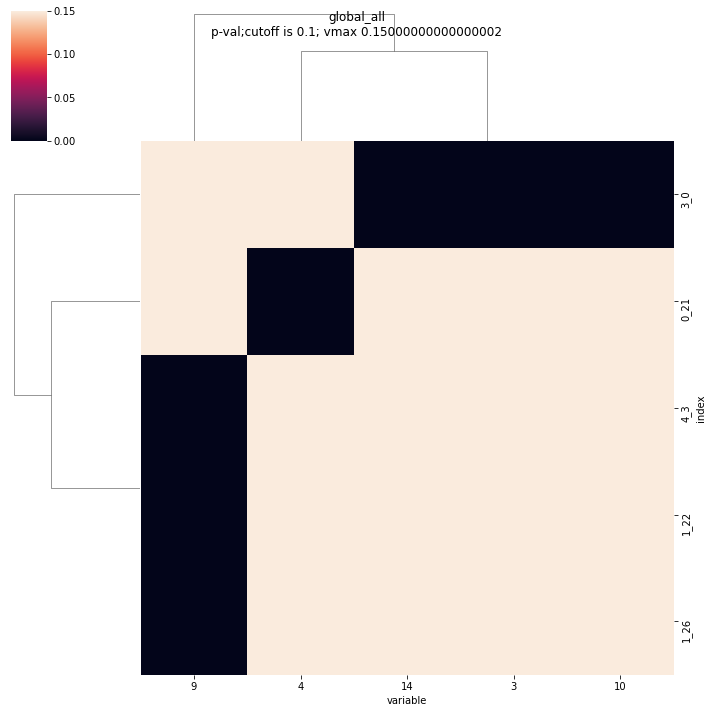

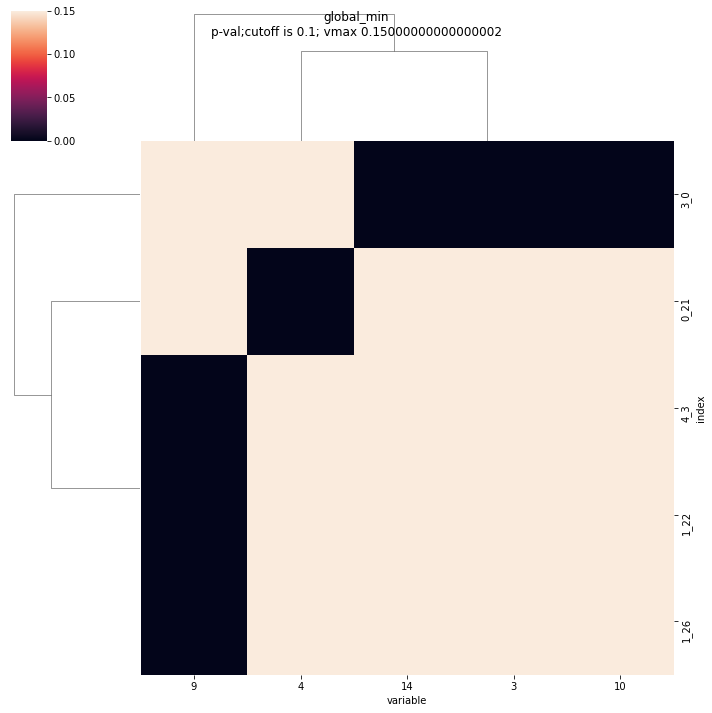

In [8]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl


# Run init hypergeo
cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
               clone_col, all_dir)
## Run shuffle
print("Running hypergeo shuffle and saving sig results")
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
                                                  atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

# # plot just the counts
# print("plotting counts")
# groups["log2_count"] = np.log2(groups["count"]+1)
# g = sns.clustermap(groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
# plt.gca().set_title("log2 ncells")
# plt.savefig(join(all_dir, "ncells.png"))


# print("Running hypergeo and saving sig results")
# output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)
# bh_enrichment_df.to_csv(join(all_dir, "hypergeo_padjusted.csv"))
# output_df.to_csv(join(all_dir, "hypergeo_padjusted_sigOnly.csv"))
    
# if output_df.shape[0] == 0:   
#     g = sns.heatmap(-np.log10(bh_enrichment_df.fillna(1)))
#     g.fig.suptitle("No groups were significant")
# else:
#     g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                    row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
# plt.savefig(join(all_dir, "hypergeo_padjusted_sigOnly.png"))

# init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                           clones=clones, atac_cl=atac_cl)

# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=n_shuffle, 
#                               to_parallel=True, n_cpus=24)

# results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment_df, p_thresh, clone_map, atac_col, 
#                                                       all_dir=sim_all_dir)

In [9]:
out_df

,index,variable,value,method
4,3_0,3,0.0,clone_all
7,0_21,4,0.0,clone_all
14,1_22,9,0.0,clone_all
15,1_26,9,0.0,clone_all
17,4_3,9,0.0,clone_all
22,3_0,10,0.0,clone_all
40,3_0,14,0.0,clone_all
4,3_0,3,0.0,clone_min
7,0_21,4,0.0,clone_min
14,1_22,9,0.0,clone_min


In [10]:
# results_df

# ## Plot shuffle p-value heatmap for each method 

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

# ## Same but log10

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     min_m = min(val.loc[val["value"] != 0 , "value"])
#     val.loc[val["value"] == 0 ,"value"] = min_m
    
#     g = sns.clustermap(-np.log10(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1)))
#     plt.suptitle(ind)
#     g.ax_cbar.set(title=f"-log10 p-val;cutoff is {-np.log10(p_thresh)}")
#     # g.ax_cbar.set(title="-log10 p-value")

    
    

# ## Save significant results_df

# out_df = results_df.rename({"value":"p_value shuffle", "index":"clone", "variable":"lineage"}, axis=1)
# out_df = out_df[out_df["p_value shuffle"]<p_thresh]

# init_p_df = init_bh_enrichment.reset_index().melt(id_vars=["index"]).rename({"variable":"lineage", "index":"clone",
#                                                                           "value": "BH_p_adj"},axis=1).set_index(["clone", "lineage"])
# init_p_df
# #pd.merge(init_p_df, out_df, on=["clone", "lineage"], how="inner" )

# out_df["BH_p_adj"] = out_df.apply(lambda x:init_p_df.loc[(x["clone"],x["lineage"]), "BH_p_adj"], axis=1)
# out_df

# out_df.sort_values(["method", "p_value shuffle", "BH_p_adj"])

# out_df[out_df["BH_p_adj"] != 1]